In [1]:
from functions_for_all_nutrients import *
from iron_hemoglobin_functions import *

In [2]:
location_ids = [179,
 163,
 214,
 161,
 165,
 190,
 189,
 196,
 201,
 180,
 15,
 164,
 20,
 202,
 205,
 171,
 11,
 184,
 168,
 6,
 141,
 207,
 181,
 213,
 522]

# Impact (DALYs averted)

In [3]:
folic_acid = pd.read_pickle('results_raw/folic_acid.pkl')

In [4]:
#iron_bw_250 = pd.read_csv('results_raw/iron_bw_results.csv')
#iron_bw_250 = iron_bw_250.set_index(['location_id', 'measure', 'vehicle','coverage_level']).stack().reset_index()

#iron_bw_1000 = (pd.concat([iron_bw_250, iron_bw_250, iron_bw_250, iron_bw_250], ignore_index=True)
#                .rename(columns={'level_4':'draw',0:'value'})
#                .set_index(['location_id','measure','vehicle','coverage_level'])
#                .sort_index())
#draws = []
#for i in list(range(0,1000)):
#    draws.append(f'draw_{i}')
#iron_bw_1000['draw'] = draws * int(len(iron_bw_1000) / 1000)
#iron_bw_1000 = iron_bw_1000.reset_index()
#iron_bw_1000 = iron_bw_1000.pivot_table(index=['location_id', 'measure', 'vehicle','coverage_level'],
#                                       columns='draw', values='value').reset_index()
#iron_bw_1000['year'] = 2025
#iron_bw_1000['nutrient'] = 'iron'
#iron_bw_1000 = iron_bw_1000.set_index(['location_id', 'vehicle', 'coverage_level', 'year', 'measure', 'nutrient'])

iron_u5 = pd.read_pickle('results_raw/iron_u5.pkl')
iron_u5['nutrient'] = 'iron'
iron_u5 = iron_u5.loc[iron_u5.year==2025]
iron_wra = pd.read_pickle('results_raw/iron_wra.pkl')
iron_wra['nutrient'] = 'iron'

In [5]:
pop_u5 = (get_population(location_id=location_ids,
                     year_id=2019,
                     sex_id=[1,2],
                     age_group_id=[2,3,4,5],
                     gbd_round_id=6,
                     decomp_step='step4')
       .groupby('location_id')
       .sum()
       .filter(['population']))
pop_wra = (get_population(location_id=location_ids,
                     year_id=2019,
                     sex_id=2,
                     age_group_id=list(range(7,16)),
                     gbd_round_id=6,
                     decomp_step='step4')
       .groupby('location_id')
       .sum()
       .filter(['population']))
pop_tot = pop_u5 + pop_wra
frac_u5 = pop_u5 / pop_tot
frac_wra = pop_wra / pop_tot

# population weight rates
index_cols = ['location_id','vehicle','coverage_level','year','measure','nutrient']

iron_u5_rate = iron_u5.loc[iron_u5.measure=='rates_averted']
#iron_bw_rate = iron_bw_1000.reset_index().loc[iron_bw_1000.reset_index().measure=='rates_averted']
iron_wra_rate = iron_wra.loc[iron_wra.measure=='rates_averted']

iron_u5_bw_rate = (iron_u5_rate.set_index(index_cols)).reset_index() #+ iron_bw_rate.set_index(index_cols)).reset_index()
iron_u5_bw_rate = iron_u5_bw_rate.merge(frac_u5, on='location_id')
iron_wra_rate = iron_wra_rate.merge(frac_wra, on='location_id')

for i in list(range(0,1000)):
    iron_u5_bw_rate[f'draw_{i}'] = iron_u5_bw_rate[f'draw_{i}'] * iron_u5_bw_rate['population']
    iron_wra_rate[f'draw_{i}'] = iron_wra_rate[f'draw_{i}'] * iron_wra_rate['population']
    
iron_weighted_rate = (iron_u5_bw_rate.drop(columns='population').set_index(index_cols)
                     + iron_wra_rate.drop(columns='population').set_index(index_cols))

# weight PIFs
wra_ira_dalys = pd.read_pickle('results_raw/wra_ira_dalys.pkl')
wra_maternal_dalys = pd.read_pickle('results_raw/iron_maternal_dalys.pkl')
u5_iron_dalys = pd.read_pickle('results_raw/u5_ira_dalys.pkl')
tot_iron_dalys = wra_ira_dalys + wra_maternal_dalys + u5_iron_dalys

iron_u5_counts = iron_u5.loc[iron_u5.measure=='counts_averted'].set_index(index_cols)
#iron_bw_counts = iron_bw_1000.reset_index().loc[iron_bw_1000.reset_index().measure=='counts_averted'].set_index(index_cols)
iron_wra_counts = iron_wra.loc[iron_wra.measure=='counts_averted'].set_index(index_cols)

tot_iron_counts = iron_u5_counts + iron_wra_counts # + iron_bw_counts
tot_iron_pifs = (tot_iron_counts / tot_iron_dalys * 100).reset_index()
tot_iron_pifs['measure'] = 'pif'
tot_iron_pifs = tot_iron_pifs.set_index(index_cols)

iron = pd.concat([tot_iron_pifs,
                 iron_weighted_rate,
                 tot_iron_counts], sort=True).reset_index()
iron.head()

draw,location_id,vehicle,coverage_level,year,measure,nutrient,draw_0,draw_1,draw_10,draw_100,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,6,wheat flour,0.2,2025.0,pif,iron,4.273098,1.499674,2.367924,1.497847,...,2.838944,2.561471,5.642691,6.232544,1.285229,3.306057,10.801740,1.761949,3.128894,2.425758
1,6,wheat flour,0.5,2025.0,pif,iron,10.308970,3.705875,5.828385,3.701164,...,6.970467,6.271554,13.544243,14.946608,3.183730,8.055105,25.922790,4.358246,7.678418,5.980710
2,6,wheat flour,0.8,2025.0,pif,iron,15.922219,5.861079,9.181991,5.853308,...,10.954042,9.828430,20.813029,22.948970,5.047528,12.562863,39.831309,6.899512,12.060474,9.437411
3,15,wheat flour,0.2,2025.0,pif,iron,0.312118,0.139054,0.158108,0.098768,...,0.186258,0.146768,0.269614,0.397702,0.145841,0.169086,0.533380,0.157042,0.133302,0.140394
4,15,wheat flour,0.5,2025.0,pif,iron,0.778934,0.347366,0.394983,0.246788,...,0.465263,0.366646,0.673129,0.992322,0.364347,0.422338,1.331645,0.392343,0.333078,0.350786


In [6]:
zinc = pd.read_pickle('results_raw/zinc.pkl')
zinc['nutrient'] = 'zinc'
zinc_prev = pd.read_pickle('results_raw/zinc_deficiency_exposure.pkl')
zinc_prev['measure'] = 'deficiency_exposure'

vitamin_a = pd.read_pickle('results_raw/vitamin_a.pkl')
vitamin_a['nutrient'] = 'vitamin a'
vitamin_a_prev = pd.read_pickle('results_raw/vitamin_a_deficiency_exposure.pkl')
vitamin_a_prev['measure'] = 'deficiency_exposure'

results = pd.concat([folic_acid.rename(columns={'year_id':'year'}), 
                     zinc, vitamin_a, iron, vitamin_a_prev, zinc_prev], ignore_index=True, sort=True)
results['nutrient'] = results.nutrient.str.replace('vitamin a','vitamin A')
results['nutrient_name'] = results.nutrient.str.replace('_',' ').str.capitalize().str.replace('Vitamin a', 'Vitamin A')
l = get_ids('location')[['location_name','location_id']]
results = results.merge(l, on='location_id')
results['label'] = results.nutrient_name + ' in ' + results.vehicle
results = results.loc[results.year==2025]
results.head()

,coverage_level,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,...,draw_998,draw_999,location_id,measure,nutrient,vehicle,year,nutrient_name,location_name,label
9,0.2,743.496800,1479.550469,1597.952786,1083.064738,488.736716,673.982572,510.457605,647.465561,1212.476363,...,1693.312600,1520.486189,141,counts_averted,folic acid,maize flour,2025.0,Folic acid,Egypt,Folic acid in maize flour
10,0.5,1858.742000,3698.876173,3994.881966,2707.661845,1221.841789,1684.956430,1276.144012,1618.663902,3031.190907,...,4233.281499,3801.215472,141,counts_averted,folic acid,maize flour,2025.0,Folic acid,Egypt,Folic acid in maize flour
11,0.8,2973.987200,5918.201877,6391.811146,4332.258952,1954.946863,2695.930288,2041.830419,2589.862243,4849.905452,...,6773.250399,6081.944755,141,counts_averted,folic acid,maize flour,2025.0,Folic acid,Egypt,Folic acid in maize flour
21,0.2,1016.927577,1620.764474,2355.507146,2885.105359,897.596800,1118.381023,866.496853,757.477571,2210.746638,...,2244.898758,1551.782277,141,counts_averted,folic acid,wheat flour,2025.0,Folic acid,Egypt,Folic acid in wheat flour
22,0.5,2542.318942,4051.911185,5888.767865,7212.763397,2243.992000,2795.952558,2166.242132,1893.693927,5526.866595,...,5612.246894,3879.455694,141,counts_averted,folic acid,wheat flour,2025.0,Folic acid,Egypt,Folic acid in wheat flour


In [7]:
dalys_averted_by_location_and_nutrient = (results#.loc[results.coverage_level==0.8]
                       .loc[results.measure=='counts_averted']
                       .drop(columns=['year']))
dalys_averted_by_location_and_nutrient = dalys_averted_by_location_and_nutrient.groupby(['location_id','location_name','vehicle','nutrient','coverage_level']).sum().reset_index()
dalys_averted_by_location_and_nutrient.head()

,location_id,location_name,vehicle,nutrient,coverage_level,draw_0,draw_1,draw_10,draw_100,draw_101,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,6,China,industry oil,vitamin A,0.2,1710.596610,779.352312,726.872197,654.386163,827.670516,...,826.581299,1128.623706,2229.872554,1759.268181,868.538892,1234.107202,602.054579,572.807546,663.582016,827.158523
1,6,China,industry oil,vitamin A,0.5,4276.491525,1948.380781,1817.180491,1635.965407,2069.176290,...,2066.453247,2821.559265,5574.681386,4398.170454,2171.347231,3085.268005,1505.136448,1432.018864,1658.955039,2067.896308
2,6,China,industry oil,vitamin A,0.8,6842.386441,3117.409250,2907.488786,2617.544652,3310.682063,...,3306.325195,4514.494823,8919.490218,7037.072726,3474.155570,4936.428809,2408.218317,2291.230183,2654.328062,3308.634093
3,6,China,wheat flour,folic acid,0.2,9430.080049,5860.778416,3177.044254,4117.059798,4113.061077,...,7945.349823,5677.575221,10514.247487,6790.733265,3693.104991,5452.903232,3744.085150,3583.174850,5425.353198,6555.352128
4,6,China,wheat flour,folic acid,0.5,23575.200122,14651.946040,7942.610634,10292.649495,10282.652691,...,19863.374557,14193.938054,26285.618716,16976.833163,9232.762477,13632.258080,9360.212875,8957.937126,13563.382994,16388.380320


In [8]:
dalys_averted_by_location_and_vehicle = (results#.loc[results.coverage_level==0.8]
                       .loc[results.measure=='counts_averted']
                       .drop(columns=['year']))
dalys_averted_by_location_and_vehicle = dalys_averted_by_location_and_vehicle.groupby(['location_id','location_name','vehicle','coverage_level']).sum().reset_index()
dalys_averted_by_location_and_vehicle.head()

,location_id,location_name,vehicle,coverage_level,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,6,China,industry oil,0.2,1710.596610,779.352312,726.872197,654.386163,827.670516,783.804025,...,826.581299,1128.623706,2229.872554,1759.268181,868.538892,1234.107202,602.054579,572.807546,663.582016,827.158523
1,6,China,industry oil,0.5,4276.491525,1948.380781,1817.180491,1635.965407,2069.176290,1959.510064,...,2066.453247,2821.559265,5574.681386,4398.170454,2171.347231,3085.268005,1505.136448,1432.018864,1658.955039,2067.896308
2,6,China,industry oil,0.8,6842.386441,3117.409250,2907.488786,2617.544652,3310.682063,3135.216102,...,3306.325195,4514.494823,8919.490218,7037.072726,3474.155570,4936.428809,2408.218317,2291.230183,2654.328062,3308.634093
3,6,China,wheat flour,0.2,56659.774390,22544.558623,21796.471201,20760.311051,55803.366849,49986.330774,...,37130.418329,34106.409117,88092.756456,71036.888908,17890.501028,37517.881762,61562.636502,21543.122253,30960.303750,32076.333657
4,6,China,wheat flour,0.5,137581.491537,55888.290067,53793.773792,51427.647189,135012.687943,121549.191888,...,91543.878358,83840.227281,212604.849734,171147.503772,44412.860576,91795.750760,148155.341154,53395.651362,76239.524261,79329.110332


In [9]:
dalys_averted_by_nutrient_all_locations = (results#.loc[results.coverage_level==0.8]
                       .loc[results.measure=='counts_averted']
                       .drop(columns=['year']))
dalys_averted_by_nutrient_all_locations = dalys_averted_by_nutrient_all_locations.groupby(['vehicle','nutrient','coverage_level']).sum().reset_index()
dalys_averted_by_nutrient_all_locations['group'] = 'all'
dalys_averted_by_nutrient_all_locations = (dalys_averted_by_nutrient_all_locations
                                           .set_index(['group','vehicle','nutrient','coverage_level'])
                                           .drop(columns='location_id'))
dalys_averted_by_nutrient_all_locations.head()

draw_0         draw_1  \
group vehicle      nutrient   coverage_level                                 
all   industry oil vitamin A  0.2             151208.777833  111360.472800   
                              0.5             378021.944583  278401.182001   
                              0.8             604835.111333  445441.891201   
      maize flour  folic acid 0.2              29405.950540   20902.735701   
                              0.5              73514.876351   52256.839251   

                                                    draw_10       draw_100  \
group vehicle      nutrient   coverage_level                                 
all   industry oil vitamin A  0.2              52997.365180   71250.314967   
                              0.5             132493.412950  178125.787419   
                              0.8             211989.460719  285001.259870   
      maize flour  folic acid 0.2              27706.349658   27288.361187   
                              0.5              69265.874145   68220.902969   

                                                   draw_101       draw_102  \
group vehicle      nutrient   coverage_level                                 
all   industry oil vitamin A  0.2              39570.088569   50373.725452   
                              0.5              98925.221423  125934.313631   
                              0.8             158280.354278  201494.901809   
      maize flour  folic acid 0.2              23517.098053   25858.600760   
                              0.5              58792.745134   64646.501901   

                                                  draw_103       draw_104  \
group vehicle      nutrient   coverage_level                                
all   industry oil vitamin A  0.2             10224.358648  120486.492007   
                              0.5             25560.896621  301216.230018   
                              0.8             40897.434593  481945.968029   
      maize flour  folic acid 0.2             13985.331725   27204.879189   
                              0.5             34963.329312   68012.197972   

                                                   draw_105       draw_106  \
group vehicle      nutrient   coverage_level                                 
all   industry oil vitamin A  0.2              65314.151461  129004.001497   
                              0.5             163285.378653  322510.003743   
                              0.8             261256.605845  516016.005989   
      maize flour  folic acid 0.2              18786.457941   23515.875662   
                              0.5              46966.144852   58789.689156   

                                              ...       draw_990  \
group vehicle      nutrient   coverage_level  ...                  
all   industry oil vitamin A  0.2             ...   42921.666007   
                              0.5             ...  107304.165017   
                              0.8             ...  171686.664028   
      maize flour  folic acid 0.2             ...   45298.681087   
                              0.5             ...  113246.702718   

                                                   draw_991       draw_992  \
group vehicle      nutrient   coverage_level                                 
all   industry oil vitamin A  0.2             105260.468421  182838.639291   
                              0.5             263151.171054  457096.598226   
                              0.8             421041.873686  731354.557162   
      maize flour  folic acid 0.2              24144.513135   28627.876499   
                              0.5              60361.282839   71569.691247   

                                                   draw_993       draw_994  \
group vehicle      nutrient   coverage_level                                 
all   industry oil vitamin A  0.2             183847.564898   80641.604863   
                              0.5             459618.912246  201604

In [10]:
dalys_averted_by_nutrient_nei = (results#.loc[results.coverage_level==0.8]
                       .loc[results.measure=='counts_averted']
                        .loc[results.location_id.isin([214,179,163])]
                       .drop(columns=['year']))
dalys_averted_by_nutrient_nei = dalys_averted_by_nutrient_nei.groupby(['vehicle','nutrient','coverage_level']).sum().reset_index()
dalys_averted_by_nutrient_nei['group'] = 'all'
dalys_averted_by_nutrient_nei = (dalys_averted_by_nutrient_nei
                                           .set_index(['group','vehicle','nutrient','coverage_level'])
                                           .drop(columns='location_id'))
dalys_averted_by_nutrient_nei.head()

draw_0         draw_1  \
group vehicle      nutrient   coverage_level                                 
all   industry oil vitamin A  0.2              61605.888498   48917.658399   
                              0.5             154014.721245  122294.145998   
                              0.8             246423.553993  195670.633598   
      maize flour  folic acid 0.2              10273.539741    6121.154685   
                              0.5              25683.849353   15302.886712   

                                                   draw_10       draw_100  \
group vehicle      nutrient   coverage_level                                
all   industry oil vitamin A  0.2             20125.228591   29197.353098   
                              0.5             50313.071477   72993.382744   
                              0.8             80500.914363  116789.412390   
      maize flour  folic acid 0.2              9265.453803    8638.317282   
                              0.5             23163.634507   21595.793204   

                                                  draw_101      draw_102  \
group vehicle      nutrient   coverage_level                               
all   industry oil vitamin A  0.2             20088.894926  23553.694443   
                              0.5             50222.237316  58884.236108   
                              0.8             80355.579706  94214.777772   
      maize flour  folic acid 0.2              7510.018259  11249.280103   
                              0.5             18775.045646  28123.200257   

                                                  draw_103       draw_104  \
group vehicle      nutrient   coverage_level                                
all   industry oil vitamin A  0.2              5276.526954   46538.835203   
                              0.5             13191.317385  116347.088007   
                              0.8             21106.107817  186155.340811   
      maize flour  folic acid 0.2              4849.692060    8522.500395   
                              0.5             12124.230150   21306.250987   

                                                   draw_105       draw_106  \
group vehicle      nutrient   coverage_level                                 
all   industry oil vitamin A  0.2              28109.530183   60332.326981   
                              0.5              70273.825459  150830.817452   
                              0.8             112438.120734  241329.307923   
      maize flour  folic acid 0.2               6611.539778    7696.544085   
                              0.5              16528.849445   19241.360211   

                                              ...      draw_990  \
group vehicle      nutrient   coverage_level  ...                 
all   industry oil vitamin A  0.2             ...  15401.391820   
                              0.5             ...  38503.479549   
                              0.8             ...  61605.567278   
      maize flour  folic acid 0.2             ...  20888.487942   
                              0.5             ...  52221.219854   

                                                   draw_991       draw_992  \
group vehicle      nutrient   coverage_level                                 
all   industry oil vitamin A  0.2              37653.325221   76397.011788   
                              0.5              94133.313052  190992.529470   
                              0.8             150613.300883  305588.047152   
      maize flour  folic acid 0.2              11103.370072   11532.577653   
                              0.5              27758.425179   28831.444132   

                                                   draw_993       draw_994  \
group vehicle      nutrient   coverage_level                                 
all   industry oil vitamin A  0.2              63244.291644   32916.270211   
                              0.5             158110.729110   82290.675528   
                 

In [11]:
dalys_averted_by_vehicle_all_locations = (results#.loc[results.coverage_level==0.8]
                       .loc[results.measure=='counts_averted']
                       .drop(columns=['year']))
dalys_averted_by_vehicle_all_locations = dalys_averted_by_vehicle_all_locations.groupby(['vehicle','coverage_level']).sum().reset_index()
dalys_averted_by_vehicle_all_locations['group'] = 'all'
dalys_averted_by_vehicle_all_locations = (dalys_averted_by_vehicle_all_locations
                                           .set_index(['group','vehicle','coverage_level'])
                                           .drop(columns='location_id'))
dalys_averted_by_vehicle_all_locations.head()

draw_0         draw_1  \
group vehicle      coverage_level                                 
all   industry oil 0.2             151208.777833  111360.472800   
                   0.5             378021.944583  278401.182001   
                   0.8             604835.111333  445441.891201   
      maize flour  0.2             122626.578876   64194.464808   
                   0.5             304235.994631  160102.323606   

                                         draw_10       draw_100  \
group vehicle      coverage_level                                 
all   industry oil 0.2              52997.365180   71250.314967   
                   0.5             132493.412950  178125.787419   
                   0.8             211989.460719  285001.259870   
      maize flour  0.2              59037.221218   60366.410184   
                   0.5             147298.913420  150671.854885   

                                        draw_101       draw_102      draw_103  \
group vehicle      coverage_level                                               
all   industry oil 0.2              39570.088569   50373.725452  10224.358648   
                   0.5              98925.221423  125934.313631  25560.896621   
                   0.8             158280.354278  201494.901809  40897.434593   
      maize flour  0.2              75252.431485   75726.296877  24440.270886   
                   0.5             186939.513190  188432.630570  61064.724584   

                                        draw_104       draw_105  \
group vehicle      coverage_level                                 
all   industry oil 0.2             120486.492007   65314.151461   
                   0.5             301216.230018  163285.378653   
                   0.8             481945.968029  261256.605845   
      maize flour  0.2              91368.317643   56691.474801   
                   0.5             227393.015170  141311.289247   

                                        draw_106  ...       draw_990  \
group vehicle      coverage_level                 ...                  
all   industry oil 0.2             129004.001497  ...   42921.666007   
                   0.5             322510.003743  ...  107304.165017   
                   0.8             516016.005989  ...  171686.664028   
      maize flour  0.2             110315.797811  ...   86086.482975   
                   0.5             273234.225698  ...  214660.253653   

                                        draw_991       draw_992  \
group vehicle      coverage_level                                 
all   industry oil 0.2             105260.468421  182838.639291   
                   0.5             263151.171054  457096.598226   
                   0.8             421041.873686  731354.557162   
      maize flour  0.2              70850.535373  112461.059266   
                   0.5             176631.924653  279246.810375   

                                        draw_993       draw_994  \
group vehicle      coverage_level                                 
all   industry oil 0.2             183847.564898   80641.604863   
                   0.5             459618.912246  201604.012157   
                   0.8             735390.259594  322566.419451   
      maize flour  0.2             130262.086814   57552.787593   
                   0.5             323192.402487  143614.600209   

                                        draw_995       draw_996  \
group vehicle      coverage_level                                 
all   industry oil 0.2              69999.548562   64194.529309   
                   0.5             174998.871405  160486.323273   
                   0.8             279998.194248  256778.117238   
      maize flour  0.2              81541.203132   87119.735671   
                   0.5             202996.327184  216694.224025   

                                        draw_997       draw_998       draw_999  
group vehicle      coverage_level                                   

In [12]:
dalys_averted_by_vehicle_nei = (results#.loc[results.coverage_level==0.8]
                       .loc[results.measure=='counts_averted']
                                .loc[results.location_id.isin([214,179,163])]
                       .drop(columns=['year']))
dalys_averted_by_vehicle_nei = dalys_averted_by_vehicle_nei.groupby(['vehicle','coverage_level']).sum().reset_index()
dalys_averted_by_vehicle_nei['group'] = 'all'
dalys_averted_by_vehicle_nei = (dalys_averted_by_vehicle_nei
                                           .set_index(['group','vehicle','coverage_level'])
                                           .drop(columns='location_id'))
dalys_averted_by_vehicle_nei.head()

draw_0         draw_1       draw_10  \
group vehicle      coverage_level                                               
all   industry oil 0.2              61605.888498   48917.658399  20125.228591   
                   0.5             154014.721245  122294.145998  50313.071477   
                   0.8             246423.553993  195670.633598  80500.914363   
      maize flour  0.2              48876.490952   23278.522706  19241.734364   
                   0.5             121582.061248   58092.947266  48061.126153   

                                        draw_100      draw_101      draw_102  \
group vehicle      coverage_level                                              
all   industry oil 0.2              29197.353098  20088.894926  23553.694443   
                   0.5              72993.382744  50222.237316  58884.236108   
                   0.8             116789.412390  80355.579706  94214.777772   
      maize flour  0.2              18862.394190  25250.765066  28495.945683   
                   0.5              47129.964958  62886.454736  71061.137811   

                                       draw_103       draw_104       draw_105  \
group vehicle      coverage_level                                               
all   industry oil 0.2              5276.526954   46538.835203   28109.530183   
                   0.5             13191.317385  116347.088007   70273.825459   
                   0.8             21106.107817  186155.340811  112438.120734   
      maize flour  0.2              8227.430629   31015.908910   18899.918735   
                   0.5             20562.345558   77334.823977   47192.782492   

                                        draw_106  ...      draw_990  \
group vehicle      coverage_level                 ...                 
all   industry oil 0.2              60332.326981  ...  15401.391820   
                   0.5             150830.817452  ...  38503.479549   
                   0.8             241329.307923  ...  61605.567278   
      maize flour  0.2              36725.619508  ...  34826.216320   
                   0.5              91376.156913  ...  86916.875365   

                                        draw_991       draw_992  \
group vehicle      coverage_level                                 
all   industry oil 0.2              37653.325221   76397.011788   
                   0.5              94133.313052  190992.529470   
                   0.8             150613.300883  305588.047152   
      maize flour  0.2              29153.211535   41140.954756   
                   0.5              72773.230007  102470.441308   

                                        draw_993       draw_994  \
group vehicle      coverage_level                                 
all   industry oil 0.2              63244.291644   32916.270211   
                   0.5             158110.729110   82290.675528   
                   0.8             252977.166575  131665.080845   
      maize flour  0.2              43999.415966   23805.290136   
                   0.5             109760.538489   59439.101171   

                                        draw_995       draw_996  \
group vehicle      coverage_level                                 
all   industry oil 0.2              27348.962681   25902.759011   
                   0.5              68372.406703   64756.897528   
                   0.8             109395.850725  103611.036045   
      maize flour  0.2              28538.773512   35459.080998   
                   0.5              71293.335120   88413.799852   

                                        draw_997      draw_998      draw_999  
group vehicle      coverage_level                                             
all   industry oil 0.2              28630.218837  19653.348188  12866.562734  
                   0.5              71575.547093  49133.370469  32166.406836  
                   0.8             114520.875349  78613.392751  51466.250938  
      maize flour  0.2              25974.

In [13]:
global_wheat_dalys_averted = dalys_averted_by_location_and_nutrient.loc[dalys_averted_by_location_and_nutrient.vehicle=='wheat flour']
wheat_locs = list(global_wheat_dalys_averted.location_id.unique())

global_maize_dalys_averted = dalys_averted_by_location_and_nutrient.loc[dalys_averted_by_location_and_nutrient.vehicle=='maize flour']
maize_locs = list(global_maize_dalys_averted.location_id.unique())

global_oil_dalys_averted = dalys_averted_by_location_and_nutrient.loc[dalys_averted_by_location_and_nutrient.vehicle=='oil']
oil_locs = list(global_oil_dalys_averted.location_id.unique())

global_industry_oil_dalys_averted = dalys_averted_by_location_and_nutrient.loc[dalys_averted_by_location_and_nutrient.vehicle=='industry oil']

global_wheat_dalys_averted_by_nutrient = global_wheat_dalys_averted.groupby(['vehicle','nutrient','coverage_level']).sum().drop(columns='location_id')
global_maize_dalys_averted_by_nutrient = global_maize_dalys_averted.groupby(['vehicle','nutrient','coverage_level']).sum().drop(columns='location_id')
global_oil_dalys_averted_by_nutrient = global_oil_dalys_averted.groupby(['vehicle','nutrient','coverage_level']).sum().drop(columns='location_id')
global_industry_oil_dalys_averted_by_nutrient = global_industry_oil_dalys_averted.groupby(['vehicle','nutrient','coverage_level']).sum().drop(columns='location_id')


global_wheat_dalys_averted = global_wheat_dalys_averted.groupby(['vehicle','coverage_level']).sum().drop(columns='location_id')
global_maize_dalys_averted = global_maize_dalys_averted.groupby(['vehicle','coverage_level']).sum().drop(columns='location_id')
global_oil_dalys_averted = global_oil_dalys_averted.groupby(['vehicle','coverage_level']).sum().drop(columns='location_id')
global_industry_oil_dalys_averted = global_industry_oil_dalys_averted.groupby(['vehicle','coverage_level']).sum().drop(columns='location_id')

# Micronutrient deficiency attributable DALYs (total burden envelope)

In [14]:
gbd_data_directory = '/share/scratch/users/ndbs/vivarium_lsff/gbd_data'
gbd_data_filepath = f'{gbd_data_directory}/multmodel_data.hdf'
vitamin_a_dalys_hdf_key = '/vitamin_a_deficiency/dalys_attributable_bmgf_25_countries'
zinc_dalys_hdf_key = '/zinc_deficiency/dalys_attributable_bmgf_25_countries'

In [15]:
ira_dalys_u5 = pd.read_pickle('results_raw/u5_ira_dalys.pkl')
ira_dalys_wra = pd.read_pickle('results_raw/wra_ira_dalys.pkl')
maternal_dalys = pd.read_pickle('results_raw/iron_maternal_dalys.pkl')

iron_dalys = ira_dalys_u5 + ira_dalys_wra + maternal_dalys
vitamin_a_dalys = pd.read_hdf(gbd_data_filepath, key=vitamin_a_dalys_hdf_key).groupby('location_id').sum()
zinc_dalys = pd.read_hdf(gbd_data_filepath, key=zinc_dalys_hdf_key).groupby('location_id').sum()
fa_dalys = pd.read_pickle('results_raw/folic_acid_dalys').groupby('location_id').sum()

mn_dalys_by_location = (iron_dalys
                 + vitamin_a_dalys
                 + zinc_dalys
                 + fa_dalys)
mn_dalys_by_location.head()

,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,draw_106,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
location_id,,,,,,,,,,,,,,,,,,,,,
6,1.352225e+06,1.341849e+06,1.001703e+06,1.334222e+06,1.193639e+06,1.286471e+06,1.283477e+06,1.309116e+06,1.668503e+06,958728.035342,...,1.234868e+06,1.384446e+06,1.659583e+06,1.320988e+06,1.321300e+06,1.224264e+06,764029.771809,1.313533e+06,1.029890e+06,1.287957e+06
11,9.055408e+05,8.354102e+05,6.728928e+05,9.317508e+05,7.108421e+05,7.646484e+05,8.204322e+05,6.850892e+05,9.130826e+05,629046.204476,...,6.623392e+05,9.060212e+05,8.132795e+05,7.958694e+05,7.905029e+05,8.211604e+05,546235.806508,6.627602e+05,6.177880e+05,7.591108e+05
15,3.710037e+05,4.331308e+05,2.977814e+05,3.762164e+05,2.859562e+05,3.964059e+05,3.669595e+05,3.054877e+05,3.911658e+05,252668.397459,...,2.801239e+05,3.729880e+05,3.825258e+05,3.166952e+05,3.010765e+05,3.490380e+05,213448.665978,3.290144e+05,3.146947e+05,3.229646e+05
20,1.869197e+05,1.898879e+05,1.963163e+05,1.561005e+05,1.362902e+05,1.389608e+05,1.374317e+05,1.282215e+05,1.841906e+05,125997.413987,...,1.579775e+05,1.653815e+05,1.342579e+05,1.265939e+05,1.474235e+05,1.646317e+05,74085.540499,1.287894e+05,1.163872e+05,1.311288e+05
141,2.351352e+05,2.649078e+05,2.548499e+05,2.748780e+05,1.843476e+05,1.998990e+05,2.084546e+05,2.192832e+05,2.815051e+05,203932.672753,...,2.317418e+05,2.508627e+05,2.353694e+05,2.226439e+05,2.143570e+05,2.941324e+05,134210.975741,1.972311e+05,1.867533e+05,2.075047e+05


In [27]:
mn_dalys_all_locations = mn_dalys_by_location.reset_index()
mn_dalys_all_locations['group'] = 'all'
mn_dalys_all_locations = mn_dalys_all_locations.groupby('group').sum().drop(columns='location_id')

In [16]:
nei_mn_dalys = (mn_dalys_by_location.reset_index().loc[mn_dalys_by_location.reset_index().location_id.isin([214,179,163])])
nei_mn_dalys['group'] = 'all'
nei_mn_dalys = nei_mn_dalys.groupby('group').sum().drop(columns='location_id')
nei_mn_dalys.head()

,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,draw_106,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
group,,,,,,,,,,,,,,,,,,,,,
all,1.462670e+07,1.446356e+07,1.164062e+07,1.495928e+07,1.168955e+07,1.329301e+07,1.356144e+07,1.160339e+07,1.463056e+07,1.025422e+07,...,1.314321e+07,1.491473e+07,1.457440e+07,1.332327e+07,1.360475e+07,1.492939e+07,8.945974e+06,1.256045e+07,1.230415e+07,1.244429e+07


In [29]:
iron_dalys['nutrient'] = 'iron'
vitamin_a_dalys['nutrient'] = 'vitamin A'
zinc_dalys['nutrient'] = 'zinc'
fa_dalys['nutrient'] = 'folic acid'
mn_dalys_by_location_and_nutrient = pd.concat([iron_dalys, vitamin_a_dalys, zinc_dalys, fa_dalys]).reset_index().set_index(['location_id','nutrient'])
mn_dalys_by_location_and_nutrient.head()

,,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,draw_106,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
location_id,nutrient,,,,,,,,,,,,,,,,,,,,,
6,iron,1.088341e+06,1.092373e+06,762827.738394,1.088802e+06,918395.054720,1.059648e+06,1.023009e+06,1.036586e+06,1.429627e+06,744071.932942,...,1.010438e+06,1.079131e+06,1.355956e+06,1.015310e+06,1.068034e+06,951715.641645,531755.419221,991216.364213,807446.968604,1.029708e+06
11,iron,8.064069e+05,7.199461e+05,572539.557797,7.363103e+05,558856.983018,6.408518e+05,7.047883e+05,5.449609e+05,7.465499e+05,482070.153037,...,4.732959e+05,7.203136e+05,6.119321e+05,6.151569e+05,6.481918e+05,655928.444989,369832.379076,485029.011237,469226.367635,5.812303e+05
15,iron,3.075189e+05,3.083758e+05,240656.414946,3.214082e+05,229602.857165,2.929313e+05,3.194609e+05,2.376806e+05,3.327815e+05,202096.921886,...,2.424091e+05,2.949596e+05,2.726255e+05,2.546624e+05,2.460991e+05,294303.684056,144507.975077,228270.675832,232715.987554,2.445824e+05
20,iron,1.574401e+05,1.603580e+05,143060.357710,1.397496e+05,116045.909636,1.265562e+05,1.258957e+05,1.102716e+05,1.624699e+05,103148.951150,...,1.264608e+05,1.502534e+05,1.134631e+05,1.085068e+05,1.288971e+05,148589.877108,63481.018182,111151.989739,106320.587807,1.195116e+05
141,iron,2.057661e+05,2.101925e+05,169786.207807,2.142303e+05,161538.312583,1.700321e+05,1.772810e+05,1.846514e+05,2.164180e+05,136443.015449,...,1.540867e+05,1.856362e+05,1.816157e+05,1.554442e+05,1.614871e+05,208955.646262,87779.884898,142248.104591,130975.811829,1.515080e+05


In [30]:
mn_dalys_nutrient_all_locations = mn_dalys_by_location_and_nutrient.reset_index()
mn_dalys_nutrient_all_locations['group'] = 'all'
mn_dalys_nutrient_all_locations = mn_dalys_nutrient_all_locations.groupby(['group','nutrient']).sum().drop(columns='location_id')

In [19]:
nei_mn_dalys_by_nutrient = (mn_dalys_by_location_and_nutrient.reset_index()
                            .loc[mn_dalys_by_location_and_nutrient.reset_index().location_id.isin([214,179,163])]
                            .groupby('nutrient').sum()).drop(columns='location_id')
nei_mn_dalys_by_nutrient.head()

,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,draw_106,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
nutrient,,,,,,,,,,,,,,,,,,,,,
folic acid,1.558004e+06,1.995446e+06,1.589937e+06,2.229038e+06,1.778140e+06,1.860953e+06,1.457002e+06,1.687654e+06,1.583935e+06,1.683403e+06,...,3.417698e+06,2.496155e+06,2.489888e+06,2.369726e+06,2.441385e+06,3.215224e+06,2.727930e+06,3.296741e+06,2.918028e+06,3.326485e+06
iron,1.221210e+07,1.149437e+07,9.528449e+06,1.173953e+07,9.594502e+06,1.110829e+07,1.172688e+07,9.152582e+06,1.230841e+07,7.853998e+06,...,9.342887e+06,1.154681e+07,1.121279e+07,1.016403e+07,1.024146e+07,1.112239e+07,5.774541e+06,8.614314e+06,8.872408e+06,8.751477e+06
vitamin A,7.837663e+05,9.577421e+05,4.876931e+05,9.220003e+05,2.963344e+05,3.082572e+05,3.548931e+05,6.799978e+05,6.541062e+05,6.736047e+05,...,3.182487e+05,7.667273e+05,8.319189e+05,7.347574e+05,7.743206e+05,4.810415e+05,3.863394e+05,6.045967e+05,4.687977e+05,3.086069e+05
zinc,7.282479e+04,1.600136e+04,3.454539e+04,6.871143e+04,2.057180e+04,1.550243e+04,2.266820e+04,8.315691e+04,8.410340e+04,4.321352e+04,...,6.437321e+04,1.050371e+05,3.980346e+04,5.474910e+04,1.475845e+05,1.107339e+05,5.716323e+04,4.480232e+04,4.492147e+04,5.772330e+04


In [20]:
global_wheat_mn = mn_dalys_by_location_and_nutrient.reset_index()
global_wheat_mn['vehicle'] = 'wheat flour'
global_wheat_mn = global_wheat_mn.loc[global_wheat_mn.location_id.isin(wheat_locs)]
global_wheat_mn_by_nutrient = global_wheat_mn.groupby(['vehicle','nutrient']).sum().drop(columns='location_id')
global_wheat_mn = global_wheat_mn.groupby('vehicle').sum().drop(columns='location_id')

#
global_oil_mn = mn_dalys_by_location_and_nutrient.reset_index()
global_oil_mn['vehicle'] = 'oil'
global_oil_mn = global_oil_mn.loc[global_oil_mn.location_id.isin(oil_locs)]
global_oil_mn_by_nutrient = global_oil_mn.groupby(['vehicle','nutrient']).sum().drop(columns='location_id')
global_oil_mn = global_oil_mn.groupby('vehicle').sum().drop(columns='location_id')

#
global_maize_mn = mn_dalys_by_location_and_nutrient.reset_index()
global_maize_mn['vehicle'] = 'maize flour'
global_maize_mn = global_maize_mn.loc[global_maize_mn.location_id.isin(maize_locs)]
global_maize_mn_by_nutrient = global_maize_mn.groupby(['vehicle','nutrient']).sum().drop(columns='location_id')
global_maize_mn = global_maize_mn.groupby('vehicle').sum().drop(columns='location_id')

In [21]:
global_industry_oil_mn = mn_dalys_by_location_and_nutrient.reset_index()
global_industry_oil_mn['vehicle'] = 'industry oil'
global_industry_oil_mn = global_industry_oil_mn.loc[global_industry_oil_mn.location_id.isin(oil_locs)]
global_industry_oil_mn_by_nutrient = global_industry_oil_mn.groupby(['vehicle','nutrient']).sum().drop(columns='location_id')
global_industry_oil_mn = global_industry_oil_mn.groupby('vehicle').sum().drop(columns='location_id')

# PIFs

In [22]:
pif_by_location_and_vehicle = (dalys_averted_by_location_and_vehicle.set_index(['location_id','location_name','vehicle','coverage_level']) 
                               / mn_dalys_by_location * 100)
pif_by_location_and_vehicle.head()

draw_0    draw_1  \
location_id location_name vehicle      coverage_level                        
6           China         industry oil 0.2              0.126502  0.058080   
                                       0.5              0.316256  0.145201   
                                       0.8              0.506009  0.232322   
                          wheat flour  0.2              4.190114  1.680111   
                                       0.5             10.174451  4.165019   

                                                        draw_10  draw_100  \
location_id location_name vehicle      coverage_level                       
6           China         industry oil 0.2             0.072564  0.049046   
                                       0.5             0.181409  0.122616   
                                       0.8             0.290255  0.196185   
                          wheat flour  0.2             2.175942  1.555986   
                                       0.5             5.370232  3.854504   

                                                        draw_101  draw_102  \
location_id location_name vehicle      coverage_level                        
6           China         industry oil 0.2              0.069340  0.060927   
                                       0.5              0.173350  0.152317   
                                       0.8              0.277361  0.243707   
                          wheat flour  0.2              4.675064  3.885539   
                                       0.5             11.311019  9.448265   

                                                       draw_103   draw_104  \
location_id location_name vehicle      coverage_level                        
6           China         industry oil 0.2             0.023357   0.089563   
                                       0.5             0.058394   0.223907   
                                       0.8             0.093430   0.358251   
                          wheat flour  0.2             0.826351   4.672092   
                                       0.5             2.055977  11.336015   

                                                       draw_105   draw_106  \
location_id location_name vehicle      coverage_level                        
6           China         industry oil 0.2             0.048418   0.151137   
                                       0.5             0.121044   0.377842   
                                       0.8             0.193670   0.604547   
                          wheat flour  0.2             1.268288   5.281535   
                                       0.5             3.146516  12.789109   

                                                       ...  draw_990  \
location_id location_name vehicle      coverage_level  ...             
6           China         industry oil 0.2             ...  0.066937   
                                       0.5             ...  0.167342   
                                       0.8             ...  0.267747   
                          wheat flour  0.2             ...  3.006832   
                                       0.5             ...  7.413250   

                                                       draw_991   draw_992  \
location_id location_name vehicle      coverage_level                        
6           China         industry oil 0.2             0.081522   0.134363   
                                       0.5             0.203804   0.335909   
                                       0.8             0.326087   0.537454   
                          wheat flour  0.2             2.463543   5.308127   
                                       0.5             6.055870  12.810741   

                                                        draw_993  draw_994  \
location_id location_name vehicle      coverage_level                        
6           China         industry oil 0.2              0.133178  0.065734   
                                       0.5  

In [23]:
nei_mn_dalys_by_nutrient = nei_mn_dalys_by_nutrient.reset_index()
nei_mn_dalys_by_nutrient['group'] = 'all'
nei_mn_dalys_by_nutrient = nei_mn_dalys_by_nutrient.set_index(['group','nutrient'])
pif_by_nutrient_nei = ((dalys_averted_by_nutrient_nei
                                    / nei_mn_dalys_by_nutrient * 100)
                                 .reset_index()
                                 .drop(columns='group'))
pif_by_nutrient_nei['location_id'] = 2
pif_by_nutrient_nei['location_name'] = 'Nigeria, Ethiopia, and India combined'
pif_by_nutrient_nei.head()

,nutrient,vehicle,coverage_level,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,...,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999,location_id,location_name
0,folic acid,maize flour,0.2,0.659404,0.306756,0.582756,0.387536,0.422352,0.604490,0.332854,...,0.463176,0.749313,0.397225,0.507989,0.532240,0.498227,0.474450,0.506899,2,"Nigeria, Ethiopia, and India combined"
1,folic acid,maize flour,0.5,1.648510,0.766891,1.456890,0.968839,1.055881,1.511226,0.832135,...,1.157941,1.873281,0.993062,1.269972,1.330599,1.245567,1.186124,1.267246,2,"Nigeria, Ethiopia, and India combined"
2,folic acid,maize flour,0.8,2.637615,1.227025,2.331025,1.550143,1.689410,2.417961,1.331417,...,1.852706,2.997250,1.588900,2.031955,2.128959,1.992907,1.897798,2.027594,2,"Nigeria, Ethiopia, and India combined"
3,folic acid,wheat flour,0.2,2.544941,1.664981,1.772156,1.530395,1.829992,2.109330,1.226814,...,2.566786,2.804083,2.043219,2.397590,2.478128,2.129567,2.174378,2.071770,2,"Nigeria, Ethiopia, and India combined"
4,folic acid,wheat flour,0.5,6.362353,4.162453,4.430391,3.825988,4.574980,5.273326,3.067036,...,6.416966,7.010207,5.108048,5.993975,6.195319,5.323918,5.435946,5.179425,2,"Nigeria, Ethiopia, and India combined"


In [24]:
pif_nei =  ((dalys_averted_by_vehicle_nei
                                    / nei_mn_dalys* 100)
                                 .reset_index()
                                 .drop(columns='group'))
pif_nei['location_id'] = 2
pif_nei['nutrient'] = 'all'
pif_nei['location_name'] = 'Nigeria, Ethiopia, and India combined'
pif_nei.head()

,vehicle,coverage_level,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,...,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999,location_id,nutrient,location_name
0,industry oil,0.2,0.421188,0.338213,0.172888,0.195179,0.171853,0.177189,0.038908,0.401080,...,0.474691,0.241947,0.183189,0.289547,0.227939,0.159729,0.103393,2,all,"Nigeria, Ethiopia, and India combined"
1,industry oil,0.5,1.052970,0.845533,0.432220,0.487947,0.429634,0.442972,0.097271,1.002699,...,1.186727,0.604867,0.457972,0.723866,0.569848,0.399323,0.258483,2,all,"Nigeria, Ethiopia, and India combined"
2,industry oil,0.8,1.684752,1.352853,0.691552,0.780715,0.687414,0.708755,0.155633,1.604318,...,1.898763,0.967787,0.732755,1.158186,0.911757,0.638917,0.413573,2,all,"Nigeria, Ethiopia, and India combined"
3,maize flour,0.2,0.334159,0.160946,0.165298,0.126092,0.216011,0.214368,0.060668,0.267300,...,0.330245,0.174978,0.191158,0.396369,0.206794,0.227307,0.217264,2,all,"Nigeria, Ethiopia, and India combined"
4,maize flour,0.5,0.831234,0.401650,0.412874,0.315055,0.537972,0.534575,0.151624,0.666485,...,0.823826,0.436900,0.477537,0.988308,0.516700,0.567216,0.542665,2,all,"Nigeria, Ethiopia, and India combined"


In [39]:
pif_all_locations = ((dalys_averted_by_vehicle_all_locations
                                    / mn_dalys_all_locations * 100)
                                 .reset_index()
                                 .drop(columns='group'))
pif_all_locations['nutrient'] = 'all'
pif_all_locations['location_id'] = 1
pif_all_locations.head()

,vehicle,coverage_level,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,...,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999,nutrient,location_id
0,industry oil,0.2,0.575803,0.426855,0.250805,0.264610,0.193085,0.216010,0.043223,0.554388,...,0.691223,0.766655,0.330928,0.265897,0.398919,0.256930,0.241797,0.125710,all,1
1,industry oil,0.5,1.439507,1.067138,0.627011,0.661525,0.482712,0.540026,0.108059,1.385970,...,1.728058,1.916637,0.827320,0.664744,0.997299,0.642324,0.604492,0.314275,all,1
2,industry oil,0.8,2.303211,1.707421,1.003218,1.058439,0.772338,0.864041,0.172894,2.217552,...,2.764893,3.066619,1.323712,1.063590,1.595678,1.027719,0.967187,0.502840,all,1
3,maize flour,0.2,0.466962,0.246064,0.279388,0.224189,0.367199,0.324726,0.103321,0.420408,...,0.425160,0.543200,0.236179,0.309739,0.541382,0.335469,0.306467,0.299316,all,1
4,maize flour,0.5,1.158530,0.613688,0.697077,0.559566,0.912183,0.808028,0.258151,1.046291,...,1.055695,1.347731,0.589350,0.771094,1.346587,0.836770,0.764573,0.746975,all,1


In [40]:
pif_by_nutrient_all_locations = ((dalys_averted_by_nutrient_all_locations
                                    / mn_dalys_nutrient_all_locations * 100)
                                 .reset_index()
                                 .drop(columns='group'))
pif_by_nutrient_all_locations['location_id'] = 1
pif_by_nutrient_all_locations.head()

,nutrient,vehicle,coverage_level,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,...,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999,location_id
0,folic acid,maize flour,0.2,0.740692,0.483141,0.702104,0.544314,0.590169,0.635530,0.417691,...,0.443390,0.542818,0.766313,0.451873,0.519717,0.517723,0.587003,0.552956,0.529878,1
1,folic acid,maize flour,0.5,1.851731,1.207852,1.755260,1.360784,1.475424,1.588826,1.044227,...,1.108475,1.357044,1.915782,1.129683,1.299292,1.294306,1.467507,1.382391,1.324695,1
2,folic acid,maize flour,0.8,2.962770,1.932564,2.808415,2.177254,2.360678,2.542121,1.670763,...,1.773561,2.171270,3.065251,1.807492,2.078867,2.070890,2.348011,2.211826,2.119513,1
3,folic acid,wheat flour,0.2,2.148260,1.539099,1.408782,1.462910,1.796479,1.832057,1.151738,...,1.581612,2.003391,2.118095,1.557653,1.703594,1.808001,1.509280,1.734590,1.551998,1
4,folic acid,wheat flour,0.5,5.370650,3.847746,3.521956,3.657274,4.491198,4.580141,2.879344,...,3.954031,5.008477,5.295239,3.894133,4.258986,4.520003,3.773199,4.336475,3.879994,1


In [42]:
# summary table that shows PIFs by location, vehicle, and nutrient (including 'all' nutrients)
a = pif_by_location_and_vehicle.reset_index()
a['nutrient'] = 'all'
b = pif_all_locations
b['nutrient'] = 'all'
b['location_id'] = 1
b['location_name'] = 'All modeled locations'
c = pif_by_nutrient_all_locations
c['location_id'] = 1
c['location_name'] = 'All modeled locations'

d = results.loc[results.measure=='pif'].drop(columns=['measure','nutrient_name','year','label'])
rsum = pd.concat([a,b,c,d,pif_by_nutrient_nei,pif_nei], ignore_index=True, sort=True)
rsum = rsum.loc[rsum.coverage_level==0.8]
rsum = (rsum.set_index([c for c in rsum.columns if 'draw' not in c])
        .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
        .filter(['mean','2.5%','97.5%'])
        .rename(columns={'2.5%':'lower','97.5%':'upper','mean':'mean_val'})
        .reset_index())
for col in ['mean_val','lower','upper']:
    rsum[f'{col}'] = rsum[f'{col}'].map('{:.2f}'.format)
rsum['value'] = (rsum['mean_val'].astype(str)
                                        +' ('
                                        +rsum['lower'].astype(str)
                                        +', '
                                        +rsum['upper'].astype(str)
                                        +')')
rsum['nutrient'] = rsum.nutrient.str.capitalize()
rsum['nutrient'] = rsum.nutrient.str.replace('Vitamin a','Vitamin A')
rsum = (rsum.pivot_table(index=['location_name','vehicle'], 
                         columns=['nutrient'], 
                         values='value', 
                         aggfunc=lambda x: ' '.join(x))
        .replace(np.nan, 'Not modeled')
        .reset_index())
rsum['order'] = np.where(rsum.vehicle=='wheat flour', 1, np.where(rsum.vehicle=='maize flour', 2, np.where(rsum.vehicle=='industry oil', 3, 4)))
rsum = (rsum.sort_values(by=['location_name','order']).drop(columns='order')
        .rename(columns={'location_name':'Location','vehicle':'Vehicle'})
        .reset_index().drop(columns='index'))
rsum.to_csv('results_plots/pif_summary_table.csv')
rsum.head()

nutrient,Location,Vehicle,All,Folic acid,Iron,Vitamin A,Zinc
0,All modeled locations,wheat flour,"4.37 (0.97, 7.83)","6.71 (4.79, 8.61)","3.45 (0.04, 7.34)","6.25 (-0.34, 10.51)","10.53 (5.72, 15.30)"
1,All modeled locations,maize flour,"1.24 (0.30, 2.19)","2.07 (1.39, 2.86)","0.87 (0.01, 1.86)","2.49 (-0.14, 4.30)","2.05 (0.97, 3.14)"
2,All modeled locations,industry oil,"1.40 (-0.10, 3.18)",Not modeled,Not modeled,"19.71 (-1.44, 33.07)",Not modeled
3,All modeled locations,oil,"0.85 (-0.05, 1.87)",Not modeled,Not modeled,"12.16 (-0.89, 21.63)",Not modeled
4,Angola,wheat flour,"2.77 (0.71, 5.22)","2.79 (1.30, 4.81)","2.60 (0.03, 6.51)","3.33 (-0.25, 7.03)","4.34 (1.59, 7.65)"


In [43]:
global_wheat_pif = ((global_wheat_dalys_averted / global_wheat_mn * 100)
                    .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1))
global_wheat_pif_by_nutrient = ((global_wheat_dalys_averted_by_nutrient / global_wheat_mn_by_nutrient * 100)
                    .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1))

global_oil_pif = ((global_oil_dalys_averted / global_oil_mn * 100)
                    .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1))
global_oil_pif_by_nutrient = ((global_oil_dalys_averted_by_nutrient / global_oil_mn_by_nutrient * 100)
                    .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1))

global_maize_pif = ((global_maize_dalys_averted / global_maize_mn * 100)
                    .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1))
global_maize_pif_by_nutrient = ((global_maize_dalys_averted_by_nutrient / global_maize_mn_by_nutrient * 100)
                    .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1))

In [44]:
global_industry_oil_pif = ((global_industry_oil_dalys_averted / global_industry_oil_mn * 100)
                    .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1))
global_industry_oil_pif_by_nutrient = ((global_industry_oil_dalys_averted_by_nutrient / global_industry_oil_mn_by_nutrient * 100)
                    .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1))

In [45]:
global_wheat_pif

count      mean       std       min      2.5%  \
vehicle     coverage_level                                                   
wheat flour 0.2             1000.0  1.149970  0.465827 -0.358359  0.251186   
            0.5             1000.0  2.848402  1.142940 -0.906341  0.627730   
            0.8             1000.0  4.516061  1.795402 -1.467065  1.003991   

                                 50%     97.5%        max  
vehicle     coverage_level                                 
wheat flour 0.2             1.139875  2.081625   3.096477  
            0.5             2.830267  5.129921   7.554616  
            0.8             4.500349  8.090133  11.803323

# Results viz

([<matplotlib.axis.XTick at 0x2b82c7228e48>,
 [Text(0.0, 0, 'Wheat Flour'),
  Text(0.22, 0, 'Maize Flour'),
  Text(0.44000000000000006, 0, 'Industry Oil'),
  Text(0.6600000000000001, 0, 'Oil')])

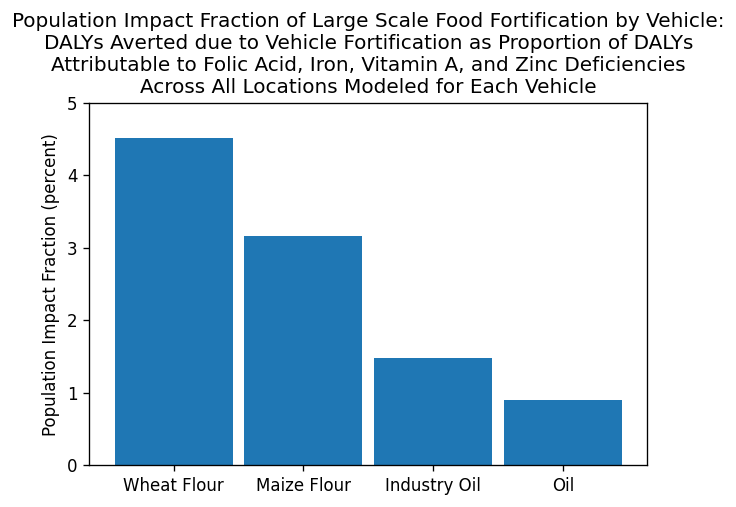

In [46]:
# GLOBAL PIF BY VEHICLE FOR ALL LOCATIONS MODELED FOR EACH VEHICLE

wheat = global_wheat_pif
maize = global_maize_pif
oil = global_oil_pif
industry_oil = global_industry_oil_pif
f, ax = plt.subplots(dpi=120)
barWidth = 0.20
spacerWidth = barWidth / 10
a = np.arange(1)
b = [x + barWidth + spacerWidth for x in a]
c = [x + barWidth + spacerWidth for x in b]
d = [x + barWidth + spacerWidth for x in c]
plt.bar(a, wheat['mean'].values, 
        width=barWidth, 
        color = 'tab:blue',
       label='Wheat flour')
plt.bar(b, maize['mean'], 
        width=barWidth, 
        color = 'tab:blue',
       label='Maize flour')
plt.bar(c, industry_oil['mean'], 
        width=barWidth, 
        color = 'tab:blue',
       label='Industry oil')
plt.bar(d, oil['mean'], 
        width=barWidth, 
        color = 'tab:blue',
       label='Oil')
plt.ylabel('Population Impact Fraction (percent)')
plt.ylim(0,5)
plt.title('Population Impact Fraction of Large Scale Food Fortification by Vehicle:\nDALYs Averted due to Vehicle Fortification as Proportion of DALYs\nAttributable to Folic Acid, Iron, Vitamin A, and Zinc Deficiencies\nAcross All Locations Modeled for Each Vehicle')
plt.xticks([a[0], b[0], c[0], d[0]], ['Wheat Flour','Maize Flour','Industry Oil','Oil'])

([<matplotlib.axis.XTick at 0x2b82c73e94a8>,
 [Text(0.0, 0, 'Wheat Flour'),
  Text(0.22, 0, 'Maize Flour'),
  Text(0.44000000000000006, 0, 'Industry Oil'),
  Text(0.6600000000000001, 0, 'Oil')])

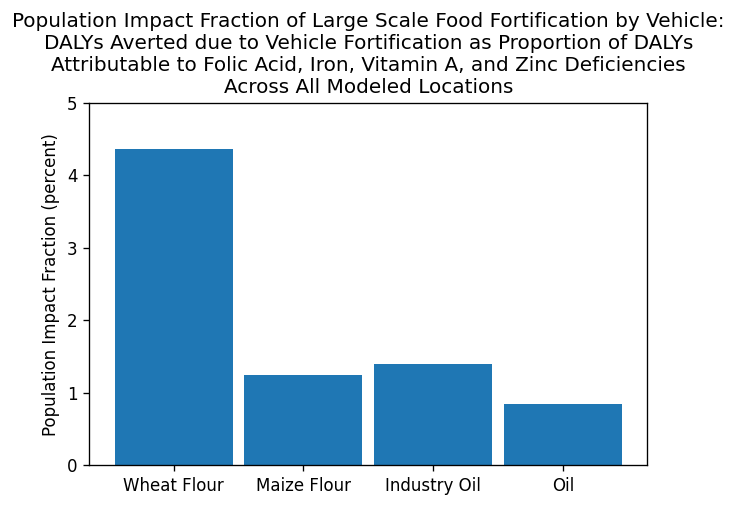

In [47]:
# GLOBAL PIF BY VEHICLE FOR ALL LOCATIONS MODELED FOR EACH VEHICLE
p = (pif_all_locations.set_index([c for c in pif_all_locations.columns if 'draw' not in c])
 .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
 .reset_index())
wheat = p.loc[p.vehicle=='wheat flour']
maize = p.loc[p.vehicle=='maize flour']
oil = p.loc[p.vehicle=='oil']
industry_oil = p.loc[p.vehicle=='industry oil']
f, ax = plt.subplots(dpi=120)
barWidth = 0.20
spacerWidth = barWidth / 10
a = np.arange(1)
b = [x + barWidth + spacerWidth for x in a]
c = [x + barWidth + spacerWidth for x in b]
d = [x + barWidth + spacerWidth for x in c]
plt.bar(a, wheat['mean'].values, 
        width=barWidth, 
        color = 'tab:blue',
       label='Wheat flour')
plt.bar(b, maize['mean'], 
        width=barWidth, 
        color = 'tab:blue',
       label='Maize flour')
plt.bar(c, industry_oil['mean'], 
        width=barWidth, 
        color = 'tab:blue',
       label='Industry oil')
plt.bar(d, oil['mean'], 
        width=barWidth, 
        color = 'tab:blue',
       label='Oil')
plt.ylabel('Population Impact Fraction (percent)')
plt.title('Population Impact Fraction of Large Scale Food Fortification by Vehicle:\nDALYs Averted due to Vehicle Fortification as Proportion of DALYs\nAttributable to Folic Acid, Iron, Vitamin A, and Zinc Deficiencies\nAcross All Modeled Locations')
plt.ylim(0,5)
plt.xticks([a[0], b[0], c[0], d[0]], ['Wheat Flour','Maize Flour','Industry Oil','Oil'])

In [48]:
pif_by_location_and_vehicle.head()

draw_0    draw_1  \
location_id location_name vehicle      coverage_level                        
6           China         industry oil 0.2              0.126502  0.058080   
                                       0.5              0.316256  0.145201   
                                       0.8              0.506009  0.232322   
                          wheat flour  0.2              4.190114  1.680111   
                                       0.5             10.174451  4.165019   

                                                        draw_10  draw_100  \
location_id location_name vehicle      coverage_level                       
6           China         industry oil 0.2             0.072564  0.049046   
                                       0.5             0.181409  0.122616   
                                       0.8             0.290255  0.196185   
                          wheat flour  0.2             2.175942  1.555986   
                                       0.5             5.370232  3.854504   

                                                        draw_101  draw_102  \
location_id location_name vehicle      coverage_level                        
6           China         industry oil 0.2              0.069340  0.060927   
                                       0.5              0.173350  0.152317   
                                       0.8              0.277361  0.243707   
                          wheat flour  0.2              4.675064  3.885539   
                                       0.5             11.311019  9.448265   

                                                       draw_103   draw_104  \
location_id location_name vehicle      coverage_level                        
6           China         industry oil 0.2             0.023357   0.089563   
                                       0.5             0.058394   0.223907   
                                       0.8             0.093430   0.358251   
                          wheat flour  0.2             0.826351   4.672092   
                                       0.5             2.055977  11.336015   

                                                       draw_105   draw_106  \
location_id location_name vehicle      coverage_level                        
6           China         industry oil 0.2             0.048418   0.151137   
                                       0.5             0.121044   0.377842   
                                       0.8             0.193670   0.604547   
                          wheat flour  0.2             1.268288   5.281535   
                                       0.5             3.146516  12.789109   

                                                       ...  draw_990  \
location_id location_name vehicle      coverage_level  ...             
6           China         industry oil 0.2             ...  0.066937   
                                       0.5             ...  0.167342   
                                       0.8             ...  0.267747   
                          wheat flour  0.2             ...  3.006832   
                                       0.5             ...  7.413250   

                                                       draw_991   draw_992  \
location_id location_name vehicle      coverage_level                        
6           China         industry oil 0.2             0.081522   0.134363   
                                       0.5             0.203804   0.335909   
                                       0.8             0.326087   0.537454   
                          wheat flour  0.2             2.463543   5.308127   
                                       0.5             6.055870  12.810741   

                                                        draw_993  draw_994  \
location_id location_name vehicle      coverage_level                        
6           China         industry oil 0.2              0.133178  0.065734   
                                       0.5  

Text(0.5, 1.0, 'Population Impact Fraction due to Large Scale Food Fortification with Iron, Folic Acid, Vitamin A, and Zinc\nDALYs Averted due to fortification as a proportion of all iron, folic acid, vitamin A, and zinc deficiency attributable DALYs')

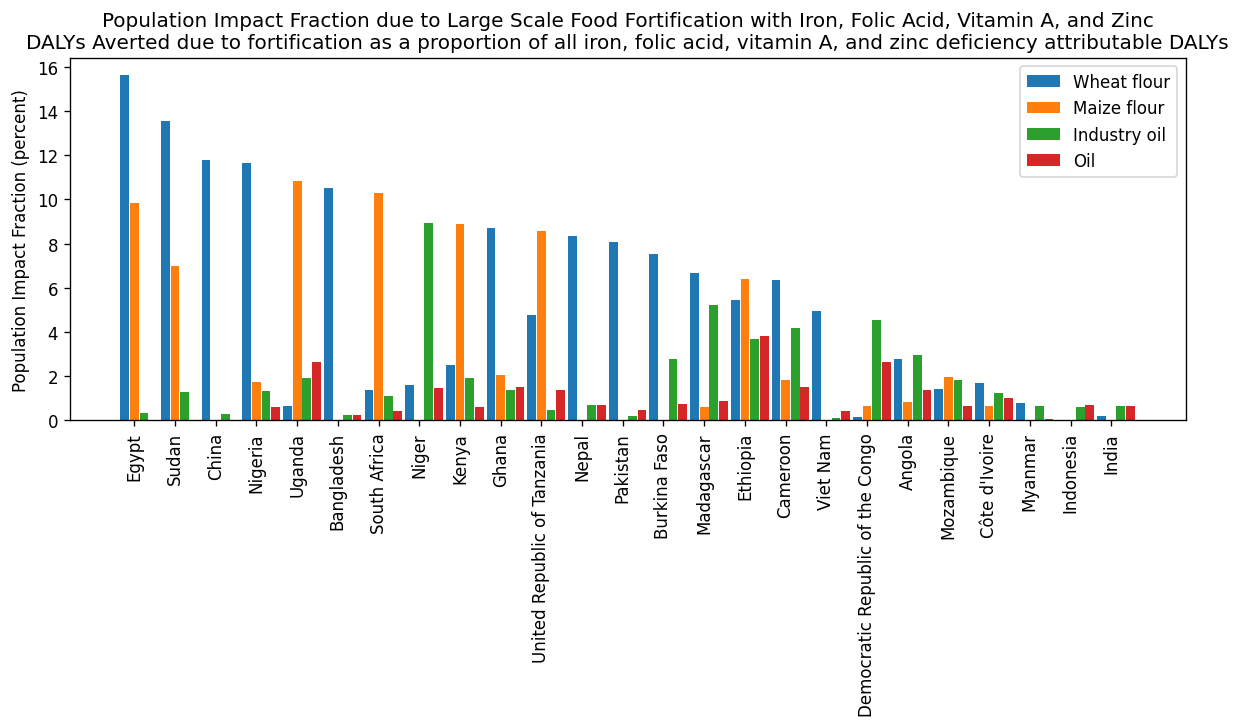

In [49]:
#LOCATION-SPECIFIC PIFS BY VEHICLE (OIL DENOMINATOR IS ALL MN DALYS)

f, ax = plt.subplots(figsize=(12, 4), dpi=120)

l = get_ids('location')
l = l[l['location_id'].isin(location_ids)]

plot = (pif_by_location_and_vehicle
        .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
        .reset_index())
plot = plot.loc[plot.coverage_level==0.8]

order = plot.groupby(['location_id','location_name'])['mean'].max().reset_index().sort_values(by='mean', ascending=False)
order['order'] = list(range(0,25))
order = order.drop(columns='mean')

plot = plot.merge(order, on=['location_name','location_id']).sort_values(by='order')

oil = plot.loc[plot.vehicle=='oil']
oil = order.merge(oil, on=['location_id','location_name','order'], how='left').sort_values(by='order')

industry_oil = plot.loc[plot.vehicle=='industry oil']
industry_oil = order.merge(industry_oil, on=['location_id','location_name','order'], how='left').sort_values(by='order')

maize = plot.loc[plot.vehicle=='maize flour']
maize = order.merge(maize, on=['location_id','location_name','order'], how='left').sort_values(by='order')

wheat = plot.loc[plot.vehicle=='wheat flour']
wheat = order.merge(wheat, on=['location_id','location_name','order'], how='left').sort_values(by='order')

barWidth = 0.215
spacerWidth = barWidth / 10
a = np.arange(25)
b = [x + barWidth + spacerWidth for x in a]
c = [x + barWidth + spacerWidth for x in b]
d = [x + barWidth + spacerWidth for x in c]


plt.bar(a, wheat['mean'], 
        width=barWidth, label='Wheat flour')
plt.bar(b, maize['mean'], 
        width=barWidth, label='Maize flour')
plt.bar(c, industry_oil['mean'], 
        width=barWidth, label='Industry oil')
plt.bar(d, oil['mean'], 
        width=barWidth, label='Oil')

plt.legend(loc='upper right')
plt.xticks(b, oil.location_name.values, rotation=90)
plt.ylabel('Population Impact Fraction (percent)')
plt.title('Population Impact Fraction due to Large Scale Food Fortification with Iron, Folic Acid, Vitamin A, and Zinc\nDALYs Averted due to fortification as a proportion of all iron, folic acid, vitamin A, and zinc deficiency attributable DALYs')
#plt.suptitle('DALYs Averted due to fortification as a proportion of all iron, folic acid, vitamin A, and zinc deficiency attributable DALYs')


/ihme/code/central_comp/miniconda_svc-ccomp/envs/v108/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Text(0.5, 1.0, 'Population Impact Fraction due to Large Scale Food Fortification with Iron, Folic Acid, Vitamin A, and Zinc\nDALYs Averted due to fortification as a proportion of DALYs attributable to nutrient deficiencies for nutrients included in each vehicle')

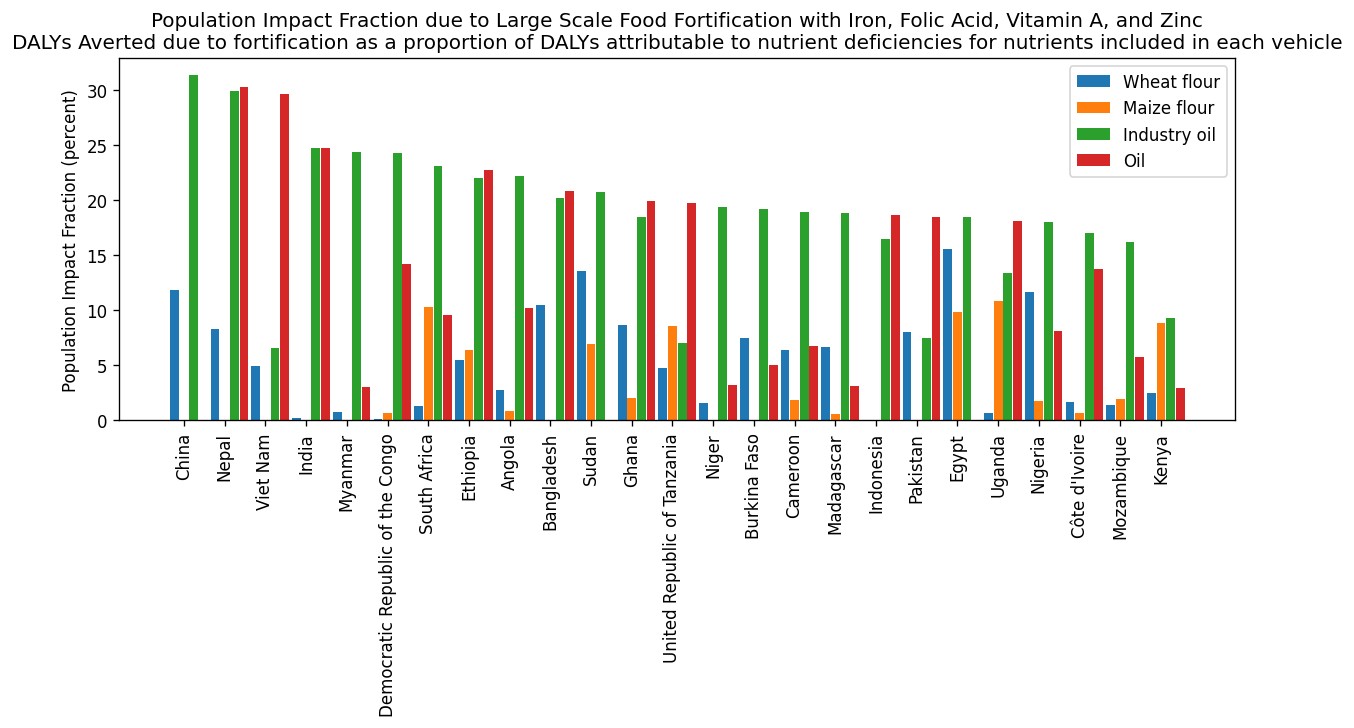

In [50]:
#LOCATION-SPECIFIC PIFS BY VEHICLE (OIL DENOMINATOR IS VITAMIN A DALYS ONLY)

f, ax = plt.subplots(figsize=(12, 4), dpi=120)

l = get_ids('location')
l = l[l['location_id'].isin(location_ids)]

plot = (pif_by_location_and_vehicle
        .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
        .reset_index())
plot = plot.loc[plot.vehicle.isin(['wheat flour','maize flour'])].loc[plot.coverage_level==0.8]
oil_plot = (results.loc[results.measure=='pif'].loc[results.coverage_level==0.8].loc[results.vehicle=='oil'])
oil_plot = oil_plot.set_index(['location_id','location_name','vehicle'])
oil_plot = (oil_plot.drop(columns=[c for c in oil_plot.columns if 'draw' not in c])
            .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
           .reset_index())

industry_oil_plot = (results.loc[results.measure=='pif'].loc[results.coverage_level==0.8].loc[results.vehicle=='industry oil'])
industry_oil_plot = industry_oil_plot.set_index(['location_id','location_name','vehicle'])
industry_oil_plot = (industry_oil_plot.drop(columns=[c for c in industry_oil_plot.columns if 'draw' not in c])
            .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
           .reset_index())


plot = pd.concat([plot, oil_plot, industry_oil_plot], ignore_index=True)

order = plot.groupby(['location_id','location_name'])['mean'].max().reset_index().sort_values(by='mean', ascending=False)
order['order'] = list(range(0,25))
order = order.drop(columns='mean')

plot = plot.merge(order, on=['location_name','location_id']).sort_values(by='order')

oil = plot.loc[plot.vehicle=='oil']
oil = order.merge(oil, on=['location_id','location_name','order'], how='left').sort_values(by='order')

industry_oil = plot.loc[plot.vehicle=='industry oil']
industry_oil = order.merge(industry_oil, on=['location_id','location_name','order'], how='left').sort_values(by='order')

maize = plot.loc[plot.vehicle=='maize flour']
maize = order.merge(maize, on=['location_id','location_name','order'], how='left').sort_values(by='order')

wheat = plot.loc[plot.vehicle=='wheat flour']
wheat = order.merge(wheat, on=['location_id','location_name','order'], how='left').sort_values(by='order')

barWidth = 0.215
spacerWidth = barWidth / 10
a = np.arange(25)
b = [x + barWidth + spacerWidth for x in a]
c = [x + barWidth + spacerWidth for x in b]
d = [x + barWidth + spacerWidth for x in c]


plt.bar(a, wheat['mean'], 
        width=barWidth, label='Wheat flour')
plt.bar(b, maize['mean'], 
        width=barWidth, label='Maize flour')
plt.bar(c, industry_oil['mean'], 
        width=barWidth, label='Industry oil')
plt.bar(d, oil['mean'], 
        width=barWidth, label='Oil')

plt.legend(loc='upper right')
plt.xticks(b, oil.location_name.values, rotation=90)
plt.ylabel('Population Impact Fraction (percent)')
plt.title('Population Impact Fraction due to Large Scale Food Fortification with Iron, Folic Acid, Vitamin A, and Zinc\nDALYs Averted due to fortification as a proportion of DALYs attributable to nutrient deficiencies for nutrients included in each vehicle')
#plt.suptitle('DALYs Averted due to fortification as a proportion of all iron, folic acid, vitamin A, and zinc deficiency attributable DALYs')


Text(0.5, 1.0, 'Population Impact Fraction due to Large Scale Food Fortification with Vitamin A\nDALYs averted as a proportion of DALYs attributable to vitamin A deficiency')

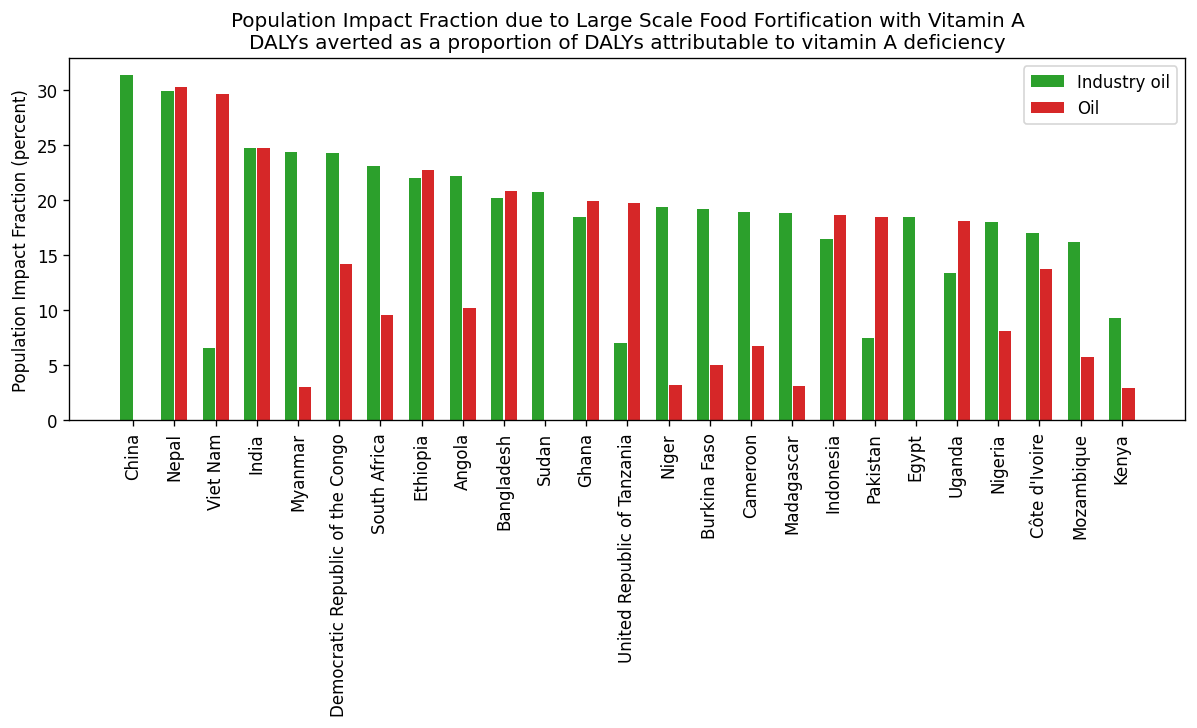

In [55]:
#LOCATION-SPECIFIC PIFS BY VEHICLE (OIL DENOMINATOR IS VITAMIN A DALYS ONLY)

f, ax = plt.subplots(figsize=(12, 4), dpi=120)

l = get_ids('location')
l = l[l['location_id'].isin(location_ids)]

oil_plot = (results.loc[results.measure=='pif'].loc[results.coverage_level==0.8].loc[results.vehicle=='oil'])
oil_plot = oil_plot.set_index(['location_id','location_name','vehicle'])
oil_plot = (oil_plot.drop(columns=[c for c in oil_plot.columns if 'draw' not in c])
            .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
           .reset_index())
industry_oil_plot = (results.loc[results.measure=='pif'].loc[results.coverage_level==0.8].loc[results.vehicle=='industry oil'])
industry_oil_plot = industry_oil_plot.set_index(['location_id','location_name','vehicle'])
industry_oil_plot = (industry_oil_plot.drop(columns=[c for c in industry_oil_plot.columns if 'draw' not in c])
            .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
           .reset_index())

plot = pd.concat([oil_plot, industry_oil_plot], ignore_index=True)
order = plot.groupby(['location_id','location_name'])['mean'].max().reset_index().sort_values(by='mean', ascending=False)
order['order'] = list(range(0,25))
order = order.drop(columns='mean')
plot = plot.merge(order, on=['location_name','location_id']).sort_values(by='order')

oil = plot.loc[plot.vehicle=='oil']
oil = order.merge(oil, on=['location_id','location_name','order'], how='left').sort_values(by='order')
industry_oil = plot.loc[plot.vehicle=='industry oil']
industry_oil = order.merge(industry_oil, on=['location_id','location_name','order'], how='left').sort_values(by='order')


barWidth = 0.3
spacerWidth = barWidth / 10
a = np.arange(25)
b = [x + barWidth + spacerWidth for x in a]

plt.bar(a, industry_oil['mean'], 
        width=barWidth, label='Industry oil', color='tab:green')
plt.bar(b, oil['mean'], 
        width=barWidth, label='Oil', color='tab:red')

plt.legend(loc='upper right')
plt.xticks(a + (barWidth + spacerWidth) / 2, oil.location_name.values, rotation=90)
plt.ylabel('Population Impact Fraction (percent)')
plt.title('Population Impact Fraction due to Large Scale Food Fortification with Vitamin A\nDALYs averted as a proportion of DALYs attributable to vitamin A deficiency')
#plt.suptitle('DALYs Averted due to fortification as a proportion of all iron, folic acid, vitamin A, and zinc deficiency attributable DALYs')


In [ ]:
def plot_pif_by_coverage_level_and_vehicle(vehicle):
    p = (pif_all_locations.set_index([c for c in pif_all_locations.columns if 'draw' not in c])
     .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
     .reset_index())
    p = p.loc[p.vehicle==vehicle]
    alt_20 = p.loc[p.coverage_level==0.2]
    alt_50 = p.loc[p.coverage_level==0.5]
    alt_80 = p.loc[p.coverage_level==0.8]

    f, ax = plt.subplots(dpi=120)
    barWidth = 0.20
    spacerWidth = barWidth / 10
    a = np.arange(1)
    b = [x + barWidth + spacerWidth for x in a]
    c = [x + barWidth + spacerWidth for x in b]
    d = [x + barWidth + spacerWidth for x in c]
    plt.bar(a, alt_20['mean'].values, 
            width=barWidth, 
            color = 'tab:blue')
    plt.bar(b, alt_50['mean'], 
            width=barWidth, 
            color = 'tab:blue')
    plt.bar(c, alt_80['mean'], 
            width=barWidth, 
            color = 'tab:blue')


    plt.ylabel('Population Impact Fraction (percent)')
    plt.title(f'Population Impact Fraction of Large Scale Food Fortification by Vehicle:\nDALYs Averted due to Vehicle Fortification as Proportion of DALYs\nAttributable to Folic Acid, Iron, Vitamin A, and Zinc Deficiencies\nAll Modeled Locations, {vehicle.capitalize()}')
    plt.ylim(0,5)
    plt.xticks([a[0], b[0], c[0]], ['20% Scale-Up','50% Scale-Up','80% Scale-Up'])

In [ ]:
plot_pif_by_coverage_level_and_vehicle('oil')

In [ ]:
pif_by_location_and_vehicle.head()

In [ ]:
p = (pif_by_location_and_vehicle#.set_index([c for c in pif_by_location_and_vehicle.columns if 'draw' not in c])
 .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
 .reset_index())
p = p.loc[p.vehicle==vehicle]
alt_20 = p.loc[p.location_id==214]
alt_50 = p.loc[p.location_id==179]
alt_80 = p.loc[p.location_id==163]
alt_20

In [ ]:
def nei_pif_by_vehicle(vehicle, india=True):
    p = (pif_by_location_and_vehicle#.set_index([c for c in pif_all_locations.columns if 'draw' not in c])
     .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
     .reset_index())
    p = p.loc[p.vehicle==vehicle].loc[p.coverage_level==0.8]
    alt_20 = p.loc[p.location_id==214]
    alt_50 = p.loc[p.location_id==179]
    alt_80 = p.loc[p.location_id==163]

    f, ax = plt.subplots(dpi=120)
    barWidth = 0.20
    spacerWidth = barWidth / 10
    a = np.arange(1)
    b = [x + barWidth + spacerWidth for x in a]
    c = [x + barWidth + spacerWidth for x in b]
    d = [x + barWidth + spacerWidth for x in c]
    plt.bar(a, alt_20['mean'].values, 
            width=barWidth, 
            color = 'tab:blue')
    plt.bar(b, alt_50['mean'], 
            width=barWidth, 
            color = 'tab:blue')
    plt.xticks([a[0], b[0]], ['Nigeria','Ethiopia'])
    if india:
        plt.bar(c, alt_80['mean'], 
                width=barWidth, 
                color = 'tab:blue')
        plt.xticks([a[0], b[0], c[0]], ['Nigeria','Ethiopia','India'])


    plt.ylabel('Population Impact Fraction (percent)')
    plt.title(f'Population Impact Fraction of Large Scale Food Fortification by Vehicle:\nDALYs Averted due to Vehicle Fortification as Proportion of DALYs\nAttributable to Folic Acid, Iron, Vitamin A, and Zinc Deficiencies\n80% Coverage Scale-Up, {vehicle.capitalize()}')
    plt.ylim(0,12)
    #plt.xticks([a[0], b[0], c[0]], ['Nigeria','Ethiopia','India'])

In [ ]:
nei_pif_by_vehicle('oil')

In [ ]:
def plot_pif_by_coverage_level_and_vehicle(vehicle):
    p = (pif_nei.set_index([c for c in pif_all_locations.columns if 'draw' not in c])
     .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
     .reset_index())
    p = p.loc[p.vehicle==vehicle]
    alt_20 = p.loc[p.coverage_level==0.2]
    alt_50 = p.loc[p.coverage_level==0.5]
    alt_80 = p.loc[p.coverage_level==0.8]

    f, ax = plt.subplots(dpi=120)
    barWidth = 0.20
    spacerWidth = barWidth / 10
    a = np.arange(1)
    b = [x + barWidth + spacerWidth for x in a]
    c = [x + barWidth + spacerWidth for x in b]
    d = [x + barWidth + spacerWidth for x in c]
    plt.bar(a, alt_20['mean'].values, 
            width=barWidth, 
            color = 'tab:blue')
    plt.bar(b, alt_50['mean'], 
            width=barWidth, 
            color = 'tab:blue')
    plt.bar(c, alt_80['mean'], 
            width=barWidth, 
            color = 'tab:blue')


    plt.ylabel('Population Impact Fraction (percent)')
    plt.title(f'Population Impact Fraction of Large Scale Food Fortification by Vehicle:\nDALYs Averted due to Vehicle Fortification as Proportion of DALYs\nAttributable to Folic Acid, Iron, Vitamin A, and Zinc Deficiencies\nNigeria, Ethiopia, and India combined, {vehicle.capitalize()}')
    plt.ylim(0,4)
    plt.xticks([a[0], b[0], c[0]], ['20% Scale-Up','50% Scale-Up','80% Scale-Up'])

In [ ]:
plot_pif_by_coverage_level_and_vehicle('oil')